In [31]:
import paddle

# 将图像值规范化到0~1之间

def transform(image):
    image = paddle.to_tensor(image/255, dtype="float32")
    image = paddle.unsqueeze(image, axis=0)
    return image

In [32]:
import paddle.io as io
import paddle.optimizer as optimizer
import paddle.nn.functional as F

from nndl_7 import RunnerV3
from paddle.vision.models import LeNet
from paddle.vision.datasets import MNIST

# 固定随机种子
paddle.seed(0)

# 准备数据
# 确保从paddle.vision.datasets.MNIST中加载的图像数据是np.ndarray类型
paddle.vision.image.set_image_backend('cv2')
train_dataset = MNIST(mode='train', transform=transform)

# 迭代器加载数据集
# 为保证每次输出结果相同，没有设置shuffle=True，真实模型训练场景需要开启
train_loader1 = io.DataLoader(train_dataset, batch_size=16)
# 定义网络
model1 = LeNet()
# 定义优化器，使用随机梯度下降（SGD）优化器
opt1 = optimizer.SGD(learning_rate=0.01, parameters=model1.parameters())
# 定义损失函数
loss_fn = F.cross_entropy
# 定义runner类
runner1 = RunnerV3(model=model1, optimizer=opt1, loss_fn=loss_fn, metric=None)
runner1.train(train_loader=train_loader1, dev_loader=None, num_epochs=30, log_steps=0, save_path='./model_opt_reg/LeNet-batch_size-16.pdparams')

model2 = LeNet()
train_loader2 = io.DataLoader(train_dataset, batch_size=32)
opt2 = optimizer.SGD(learning_rate=0.02, parameters=model2.parameters())
runner2 = RunnerV3(model=model2, optimizer=opt2, loss_fn=loss_fn, metric=None)
runner2.train(train_loader=train_loader2, dev_loader=None, num_epochs=30, log_steps=0, save_path='./model_opt_reg/LeNet-batch_size-32.pdparams')

model3 = LeNet()
train_loader3 = io.DataLoader(train_dataset, batch_size=64)
opt3 = optimizer.SGD(learning_rate=0.04, parameters=model3.parameters())
runner3 = RunnerV3(model=model3, optimizer=opt3, loss_fn=loss_fn, metric=None)
runner3.train(train_loader=train_loader3, dev_loader=None, num_epochs=30, log_steps=0, save_path='./model_opt_reg/LeNet-batch_size-64.pdparams')

model4 = LeNet()
train_loader4 = io.DataLoader(train_dataset, batch_size=128)
opt4 = optimizer.SGD(learning_rate=0.08, parameters=model4.parameters())
runner4 = RunnerV3(model=model4, optimizer=opt4, loss_fn=loss_fn, metric=None)
runner4.train(train_loader=train_loader3, dev_loader=None, num_epochs=30, log_steps=0, save_path='./model_opt_reg/LeNet-batch_size-128.pdparams')

model5 = LeNet()
train_loader5 = io.DataLoader(train_dataset, batch_size=256)
opt5 = optimizer.SGD(learning_rate=0.16, parameters=model5.parameters())
runner5 = RunnerV3(model=model5, optimizer=opt5, loss_fn=loss_fn, metric=None)
runner5.train(train_loader=train_loader5, dev_loader=None, num_epochs=30, log_steps=0, save_path='./model_opt_reg/LeNet-batch_size-256.pdparams')

[Train] Training done!
[Train] Training done!
[Train] Training done!
[Train] Training done!
[Train] Training done!


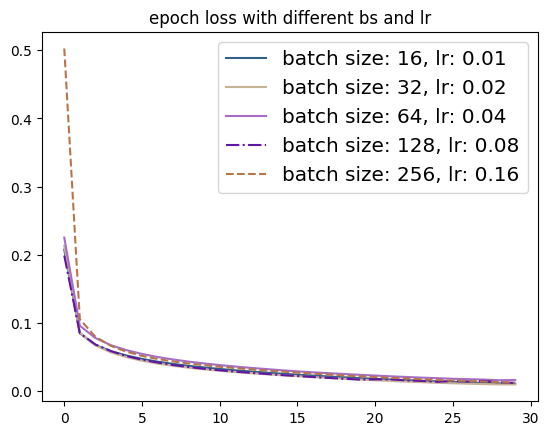

In [34]:
%matplotlib inline
import matplotlib.pyplot as plt

# 绘制每个回合的损失
plt.plot(runner1.train_epoch_losses, label="batch size: 16, lr: 0.01", c="#316189")
plt.plot(runner2.train_epoch_losses, label='batch size: 32, lr: 0.02', c="#c7b298")
plt.plot(runner3.train_epoch_losses, label="batch size: 64, lr: 0.04", c="#a56dc6")
plt.plot(runner4.train_epoch_losses, label='batch size: 128, lr: 0.08', c="#6214a5", linestyle='-.')
plt.plot(runner5.train_epoch_losses, label='batch size: 256, lr: 0.16', c="#b8754a", linestyle='--')
plt.legend(fontsize='x-large')
plt.title('epoch loss with different bs and lr')
plt.savefig('opt-mnist-loss.pdf')
plt.show()

不同优化算法的比较分析

In [35]:
from nndl_7.op import Op

class OptimizedFunction(Op):
    def __init__(self, w):
        super(OptimizedFunction, self).__init__()
        self.w = w
        self.params = {'x': 0}
        self.grads = {'x': 0}

    def forward(self, x):
        self.params['x'] = x
        return paddle.matmul(self.w.T, paddle.square(self.params['x']))
    
    def backward(self):
        self.grads['x'] = 2 * paddle.multiply(self.w.T, self.params['x'])

In [36]:
def train_f(model, optimizer, x_init, epoch):
    """
    训练函数
    输入：
        - model：被优化函数
        - optimizer：优化器
        - x_init：x初始值
        - epoch：训练回合数
    """
    x = x_init
    all_x = []
    losses = []
    for i in range(epoch):
        all_x.append(x.numpy())
        loss = model(x)
        losses.append(loss)
        model.backward()
        optimizer.step()
        x = model.params['x']

    return paddle.to_tensor(all_x), losses

In [37]:
import numpy as np

class Visualization(object):
    def __init__(self):
        """
        初始化可视化类
        """
        # 只画出参数x1和x2在区间[-5, 5]的曲线部分
        x1 = np.arange(-5, 5, 0.1)
        x2 = np.arange(-5, 5, 0.1)
        x1, x2 = np.meshgrid(x1, x2) # meshgrid() 用于生成网格采样点矩阵
        self.init_x = paddle.to_tensor([x1, x2])

    def plot_2d(self, model, x, fig_name):
        """
        可视化参数更新轨迹
        """
        fig, ax = plt.subplots(figsize=(10, 6))
        cp = ax.contourf(self.init_x[0], self.init_x[1], model(self.init_x.transpose([1, 0, 2])), colors=['#e4007f', '#f19ec2', '#e86096', '#eb7aaa', '#f6c8dc', '#f5f5f5', '#000000'])
        c = ax.contour(self.init_x[0], self.init_x[1], model(self.init_x.transpose([1, 0, 2])), colors='black')
        cbar = fig.colorbar(cp)
        ax.plot(x[:, 0], x[:, 1], '-o', color="#aab590")
        ax.plot(0, 'r*', markersize=18, color="#fefefe")

        ax.set_xlabel('$x1$')
        ax.set_ylabel('$x2$')

        ax.set_xlim((-2, 5))
        ax.set_ylim((-2, 5))

        plt.savefig(fig_name)

In [38]:
import numpy as np

def train_and_plot_f(model, optimizer, epoch, fig_name):
    """
    训练模型并可视化参数更新轨迹
    """
    # 设置x的初始值
    x_init = paddle.to_tensor([3, 4], dtype='float32')
    print('x1 initiate: {}, x2 initiate: {}'.format(x_init[0].numpy(), x_init[1].numpy()))

    x, losses = train_f(model, optimizer, x_init, epoch)
    losses = np.array(losses)

    # 展示x1、x2的更新轨迹
    vis = Visualization()
    vis.plot_2d(model, x, fig_name)

x1 initiate: [3.], x2 initiate: [4.]


C:\Users\Dragon_Reed\AppData\Local\Temp\ipykernel_42544\3120997799.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  ax.plot(0, 'r*', markersize=18, color="#fefefe")


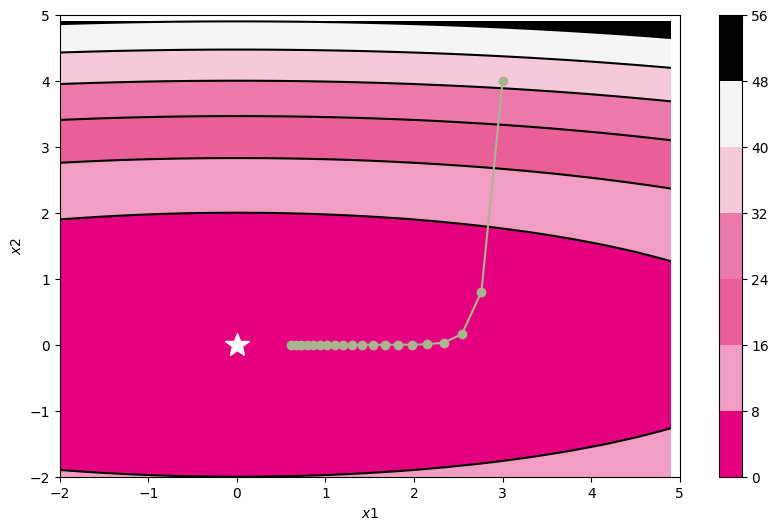

In [39]:
from nndl_7.op import SimpleBatchGD
import paddle
import matplotlib.pyplot as plt

# 固定随机种子
paddle.seed(0)

w = paddle.to_tensor([0.2, 2])
model = OptimizedFunction(w)

opt = SimpleBatchGD(init_lr=0.2, model=model)

train_and_plot_f(model=model, optimizer=opt, epoch=20, fig_name='opti-vis-para.pdf')

In [40]:
# 简单拟合实验

# 固定随机种子
paddle.seed(0)

# 随机生成shape为（1000，2）的训练数据
X = paddle.randn([1000, 2])
w = paddle.to_tensor([0.5, 0.8])
w = paddle.unsqueeze(w, axis=1)
noise = 0.01 * paddle.randn([1000])
noise = paddle.unsqueeze(noise, axis=1)

# 计算y
y = paddle.matmul(X, w) + noise

# 打印X，y样本
print("X: ", X[0].numpy())
print("y: ", y[0].numpy())

# X，y组成训练样本数据
data = paddle.concat((X, y), axis=1)
print('input data shape: ', data.shape)
print("data: ", data[0].numpy())


X:  [-0.9246624  -0.42534423]
y:  [-0.8007983]
input data shape:  [1000, 3]
data:  [-0.9246624  -0.42534423 -0.8007983 ]


In [41]:
# 定义Linear算子，实现一个线性层的前向和反向计算
class Linear(Op):
    def __init__(self, input_size, weight_init=paddle.standard_normal, bias_init=paddle.zeros):
        super(Linear, self).__init__()
        self.params = {}
        self.params['W'] = weight_init(shape=[input_size, 1])
        self.params['b'] = bias_init(shape=[1])
        self.inputs = None
        self.grads = {}

    def forward(self, inputs):
        self.inputs = inputs
        self.outputs = paddle.matmul(self.inputs, self.params['W']) + self.params['b']
        return self.outputs
    
    def backward(self, labels):
        K = self.inputs.shape[0]
        self.grads['W'] = 1./K * paddle.matmul(self.inputs.T, (self.outputs-labels))
        self.grads['b'] = 1./K * paddle.sum(self.outputs-labels, axis=0)

In [42]:
def train(data, num_epochs, batch_size, model, calculate_loss, optimizer, verbose=False):
    """
    训练神经网络
    输入：
        - data：训练样本
        - num_epochs：训练回合数
        - batch_size：批大小
        - model：实例化的模型
        - calculate_loss：损失函数
        - optimizer：优化器
        - verbose：日志显示，默认为False
    输出：
        - iter_loss：每一次迭代的损失值
        - epoch_loss：每个回合的平均损失值
    """
    # 记录每个回合损失的变化
    epoch_loss = []
    # 记录每次迭代损失的变化
    iter_loss = []
    N = len(data)
    for epoch_id in range(num_epochs):
        # np.random.shuffle(data) #不再随机打乱数据
        # 将训练数据进行拆分，每个mini_batch包含batch_size条的数据
        mini_batchs = [data[i : i+batch_size] for i in range(0, N, batch_size)]
        for iter_id, mini_batch in enumerate(mini_batchs):
            # data中前两个分量为X
            inputs = mini_batch[:, :-1]
            # data中最后一个分量为y
            labels = mini_batch[:, -1:]
            # 前向计算
            outputs = model(inputs)
            # 计算损失
            loss = calculate_loss(outputs, labels).numpy()[0]
            # 计算梯度
            model.backward(labels)
            # 梯度更新
            optimizer.step()
            iter_loss.append(loss)
        # verbose = True # 则打印当前回合的损失
        if verbose:
            print('Epoch {:3d}, loss = {:.4f}'.format(epoch_id, np.mean(iter_loss)))
        epoch_loss.append(np.mean(iter_loss))

    return iter_loss, epoch_loss


In [43]:
def plot_loss(iter_loss, epoch_loss, fig_name):
    """
    可视化损失函数的变化趋势
    """
    plt.figure(figsize=(10, 4))
    ax1 = plt.subplot(121)
    ax1.plot(iter_loss, color="#e4007f")
    plt.title('iteration loss')
    ax2 = plt.subplot(122)
    ax2.plot(epoch_loss, color="#f19ec2")
    plt.title('epoch loss')
    plt.savefig(fig_name)
    plt.show()

In [44]:
import paddle.nn as nn
def train_and_plot(optimizer, fig_name):
    """
    训练网络并画出损失函数的变化趋势
    输入：
        - optimizer：优化器
    """
    # 定义均方差损失
    mse = nn.MSELoss()
    iter_loss, epoch_loss = train(data, num_epochs=50, batch_size=64, model=model, calculate_loss=mse, optimizer=optimizer)
    plot_loss(iter_loss, epoch_loss, fig_name)

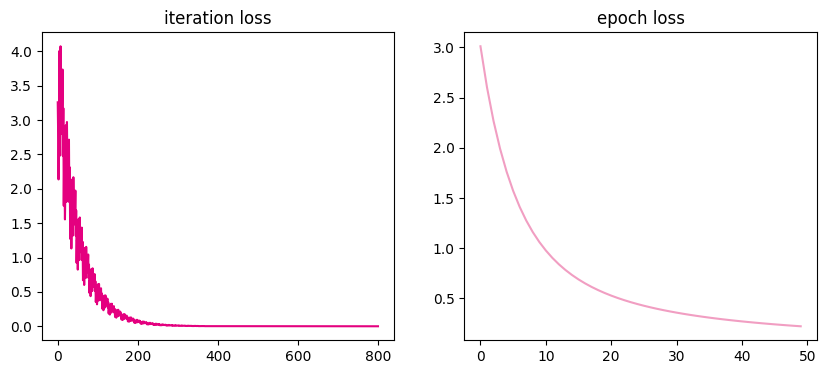

In [45]:
# 固定随机种子
paddle.seed(0)
# 定义网络结构
model = Linear(2)
# 定义优化器
opt = SimpleBatchGD(init_lr=0.01, model=model)
train_and_plot(opt, 'opti-loss.pdf')

In [46]:
paddle.seed(0)

x = data[0, :-1].unsqueeze(0)
y = data[0, -1].unsqueeze(0)

model1 = Linear(2)
print('model1 parameter W: ', model1.params['W'].numpy())
output1 = model1(x)

model2 = nn.Linear(2, 1, nn.initializer.Assign(model1.params['W']))
print('model2 parameter W:', model2.state_dict()['weight'].numpy())
output2 = model2(x)

model1.backward(y)
opt1 = SimpleBatchGD(init_lr=0.01, model=model1)
opt1.step()
print('model1 parameter W after train step: ', model1.params['W'].numpy())

opt2 = paddle.optimizer.SGD(learning_rate=0.01, parameters=model2.parameters())
loss = nn.functional.mse_loss(output2, y)/2
loss.backward()
opt2.step()
opt2.clear_grad()
print('model2 parameter W after train step: ', model2.state_dict()['weight'].numpy())

model1 parameter W:  [[-0.9246624 ]
 [-0.42534423]]
model2 parameter W: [[-0.9246624 ]
 [-0.42534423]]
model1 parameter W after train step:  [[-0.90767896]
 [-0.41753185]]
model2 parameter W after train step:  [[-0.90767896]
 [-0.41753185]]


In [47]:
from nndl_7.op import Optimizer

class Adagrad(Optimizer):
    def __init__(self, init_lr, model, epsilon):
        """
        Adagrad 优化器初始化
        输入：
            - init_lr： 初始学习率
            - model：模型，model.params存储模型参数值
            - epsilon：保持数值稳定性而设置的非常小的常数
        """
        super(Adagrad, self).__init__(init_lr=init_lr, model=model)
        self.G = {}
        for key in self.model.params.keys():
            self.G[key] = 0
        self.epsilon = epsilon

    def adagrad(self, x, gradient_x, G, init_lr):
        """
        adagrad算法更新参数，G为参数梯度平方的累计值。
        """
        G +=gradient_x ** 2
        x -= init_lr / paddle.sqrt(G + self.epsilon)*gradient_x
        return x, G
    
    def step(self):
        """
        参数更新
        """
        for key in self.model.params.keys():
            self.model.params[key], self.G[key] = self.adagrad(self.model.params[key], self.model.grads[key],
                                                               self.G[key], self.init_lr)

x1 initiate: [3.], x2 initiate: [4.]


C:\Users\Dragon_Reed\AppData\Local\Temp\ipykernel_42544\3120997799.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  ax.plot(0, 'r*', markersize=18, color="#fefefe")


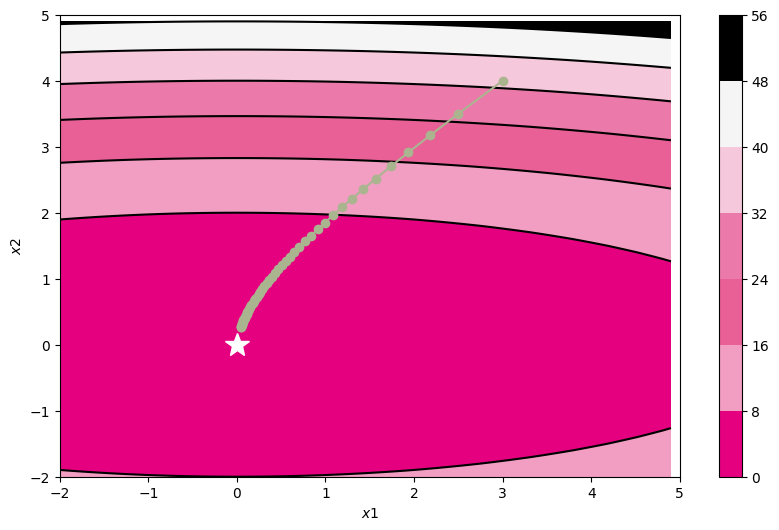

In [48]:
# 固定随机种子
paddle.seed(0)
w = paddle.to_tensor([0.2, 2])
model = OptimizedFunction(w)
opt = Adagrad(init_lr=0.5, model=model, epsilon=1e-7)
train_and_plot_f(model=model, optimizer=opt, epoch=50, fig_name='opti-vis-para2.pdf')

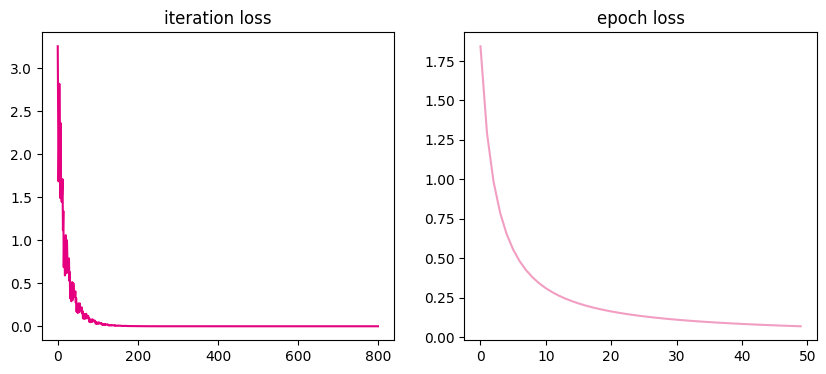

In [49]:
# 固定随机种子
paddle.seed(0)
# 定义网络结构
model = Linear(2)
# 定义优化器
opt = Adagrad(init_lr=0.1, model=model, epsilon=1e-7)
train_and_plot(opt, 'opti-loss2.pdf')

In [50]:
class RMSprop(Optimizer):
    def __init__(self, init_lr, model, beta, epsilon):
        """
        RMSprop优化器初始化
        输入：
            - init_lr：初始学习率
            - model：模型，model.params存储模型参数值
            - beta：衰减率
            - epsilon：保持数值稳定性而设置的常数
        """
        super(RMSprop, self).__init__(init_lr=init_lr, model=model)
        # self.init_lr = init_lr
        # self.model = model
        # 此两行代码 与super()... 保留一个即可，具有相同作用
        self.G = {}
        for key in self.model.params.keys():
            self.G[key] = 0
        self.beta = beta
        self.epsilon = epsilon

    def rmsprop(self, x, gradient_x, G, init_lr):
        """
        rmsprop算法更新参数，G为迭代梯度平方的加权移动平均
        """
        G = self.beta * G + (1-self.beta)*gradient_x**2
        x -= init_lr/paddle.sqrt(G+self.epsilon)*gradient_x
        return x, G
    
    def step(self):
        """参数更新"""
        for key in self.model.params.keys():
            self.model.params[key], self.G[key] = self.rmsprop(self.model.params[key], self.model.grads[key],
                                                               self.G[key], self.init_lr)

x1 initiate: [3.], x2 initiate: [4.]


C:\Users\Dragon_Reed\AppData\Local\Temp\ipykernel_42544\3120997799.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  ax.plot(0, 'r*', markersize=18, color="#fefefe")


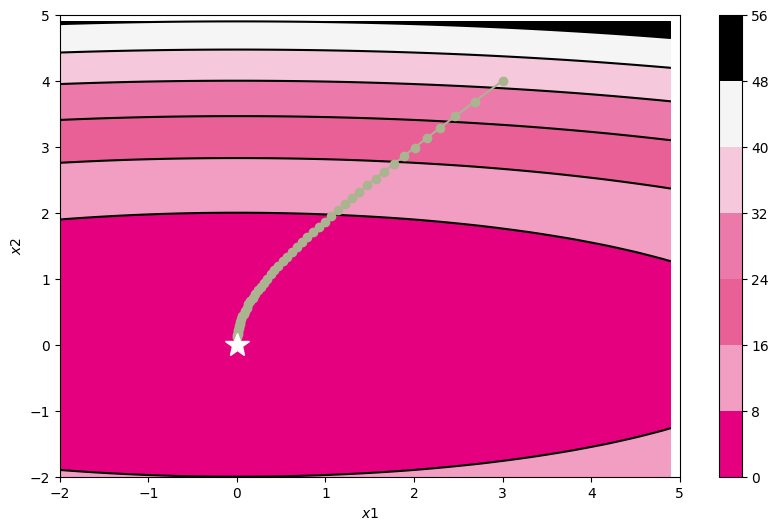

In [51]:
# 固定随机种子
paddle.seed(0)
w = paddle.to_tensor([0.2, 2])
model = OptimizedFunction(w)
opt = RMSprop(init_lr=0.1, model=model, beta=0.9, epsilon=1e-7)
train_and_plot_f(model=model, optimizer=opt,epoch=50, fig_name="opti-vis-para3.pdf")

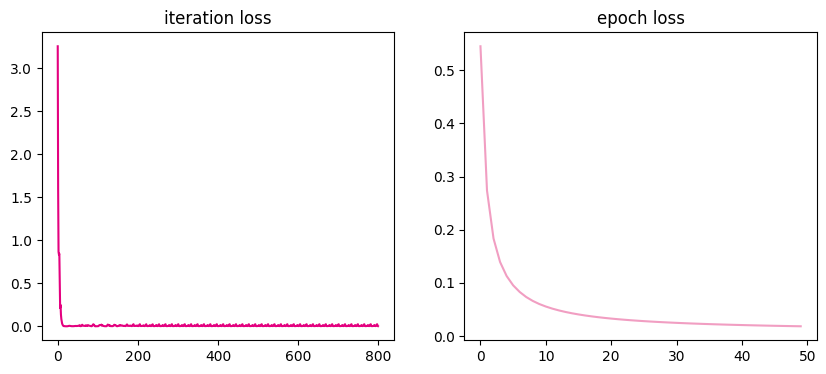

In [52]:
# 固定随机种子
paddle.seed(0)
# 定义网路结构
model = Linear(2)
# 定义优化器
opt = RMSprop(init_lr=0.1, model=model, beta=0.9, epsilon=1e-7)
train_and_plot(opt, "opti-loss3.pdf")

In [53]:
class Momentum(Optimizer):
    def __init__(self, init_lr, model, rho):
        """
        Momentum优化器初始化
        输入：
            - init_lr：初始学习率
            - model：模型，model.params存储模型参数值
            - rho：动量因子
        """
        super(Momentum, self).__init__(init_lr=init_lr, model=model)
        self.delta_x = {}
        for key in self.model.params.keys():
            print(key)
            self.delta_x[key] = 0
        self.rho = rho

    def momentum(self, x, gradient_x, delta_x, init_lr):
        """
        momentum算法更新参数，delta_x为梯度的加权移动平均
        """
        delta_x = self.rho * delta_x -init_lr*gradient_x
        x += delta_x
        return x, delta_x
    
    def step(self):
        """"参数更新"""
        for key in self.model.params.keys():
            self.model.params[key], self.delta_x[key] = self.momentum(self.model.params[key], self.model.grads[key],
                                                                      self.delta_x[key], self.init_lr)

x
x1 initiate: [3.], x2 initiate: [4.]


C:\Users\Dragon_Reed\AppData\Local\Temp\ipykernel_42544\3120997799.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  ax.plot(0, 'r*', markersize=18, color="#fefefe")


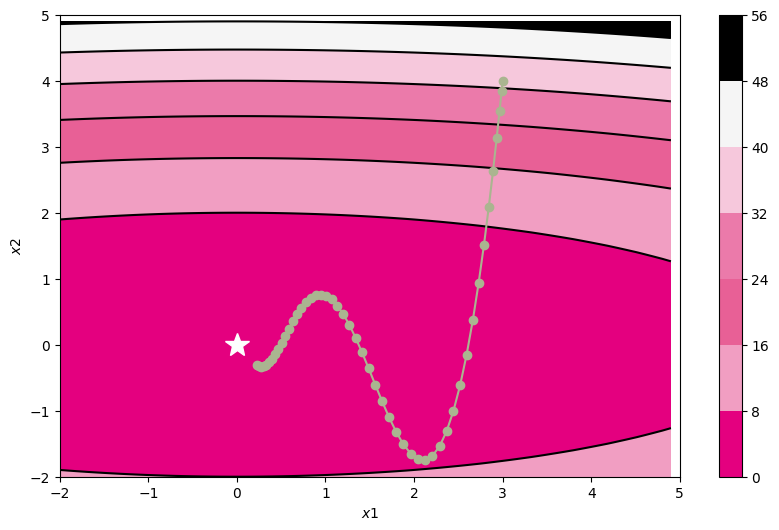

In [54]:
# 固定随机种子
paddle.seed(0)

w = paddle.to_tensor([0.2, 2])
model = OptimizedFunction(w)
opt = Momentum(init_lr=0.01, model=model, rho=0.9)
train_and_plot_f(model=model, optimizer=opt, epoch=50, fig_name="opti-vis-para4.pdf")

W
b


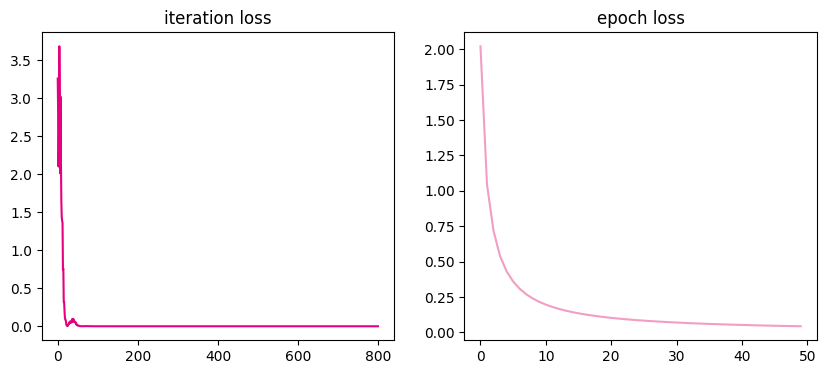

In [55]:
# 固定随机种子
paddle.seed(0)

# 定义网络结构
model = Linear(2)
# 定义优化器
opt = Momentum(init_lr=0.01, model=model, rho=0.9)
train_and_plot(optimizer=opt, fig_name="opti-loss4.pdf")

In [56]:
class Adam(Optimizer):
    def __init__(self, init_lr, model, beta1, beta2, epsilon):
        """
        Adam优化器初始化
        输入：
            - init_lr：初始学习率
            - model：模型，model.params存储模型参数值
            - beta1, beta2：移动平均的衰减率
            - epsilon：保持数值稳定性而设置的常数
        """
        super(Adam, self).__init__(init_lr=init_lr, model=model)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.M, self.G = {}, {}
        for key in self.model.params.keys():
            self.M[key]=0
            self.G[key]=0
        self.t = 1

    def adam(self, x, gradient_x, G, M, t, init_lr):
        """
        adam算法更新参数
        输入：
            - x：参数
            - G：梯度平方的加权移动平均
            - M：梯度的加权移动平均
            - t：迭代次数
            - init_lr：初始学习率
        """
        M = self.beta1*M + (1-self.beta1)*gradient_x
        G = self.beta2*G + (1-self.beta2)*gradient_x**2
        M_hat = M/(1-self.beta1**t)
        G_hat = G/(1-self.beta2**t)
        t += 1
        x -= init_lr / paddle.sqrt(G_hat + self.epsilon) * M_hat
        return x, G, M, t
    
    def step(self):
        """参数更新"""
        for key in self.model.params.keys():
            self.model.params[key], self.G[key], self.M[key], self.t = self.adam(self.model.params[key], self.model.grads[key],
                                                                                 self.G[key], self.M[key], self.t, self.init_lr)

x1 initiate: [3.], x2 initiate: [4.]


C:\Users\Dragon_Reed\AppData\Local\Temp\ipykernel_42544\3120997799.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r*" (-> color='r'). The keyword argument will take precedence.
  ax.plot(0, 'r*', markersize=18, color="#fefefe")


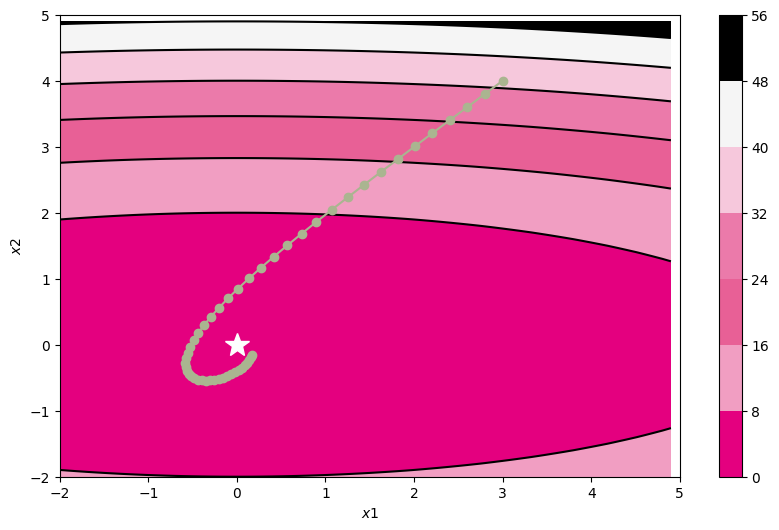

In [57]:
# 固定随机种子
paddle.seed(0)

w = paddle.to_tensor([0.2, 2])
model = OptimizedFunction(w)
opt = Adam(init_lr=0.2, model=model, beta1=0.9, beta2=0.99, epsilon=1e-7)
train_and_plot_f(model=model, optimizer=opt, epoch=50, fig_name="opti-vis-para5.pdf")

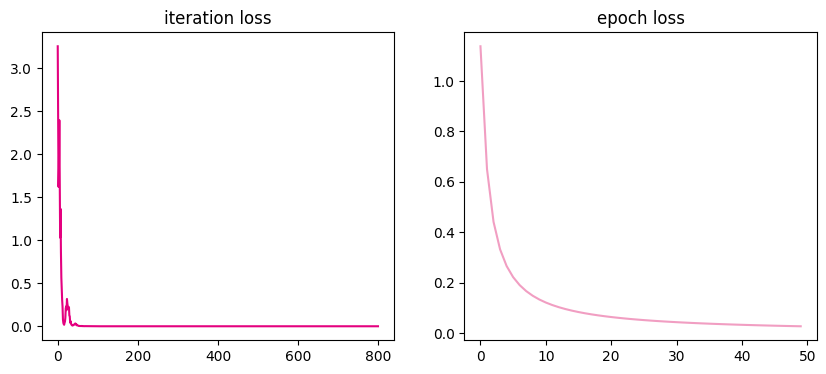

In [58]:
# 固定随机种子
paddle.seed(0)

# 定义网络结构
model = Linear(2)
# 定义优化器
opt = Adam(init_lr=0.1, model=model, beta1=0.9, beta2=0.99, epsilon=1e-7)
train_and_plot(opt, "opti-loss5.pdf")

In [59]:
# 不同优化器的3D可视化对比
class OptimizedFunction3D(Op):
    def __init__(self):
        super(OptimizedFunction3D, self).__init__()
        self.params = {'x': 0}
        self.grads = {'x': 0}

    def forward(self, x):
        self.params['x'] = x
        return x[0] ** 2 + x[1] ** 2 + x[1] ** 3 + x[0]*x[1]
    
    def backward(self):
        x =self.params['x']
        gradient1 = 2*x[0] + x[1]
        gradient2 = 2*x[1] + 3*x[1]**2 + x[0]
        self.grads['x'] = paddle.concat([gradient1, gradient2])

In [60]:
# 构建5个模型，分别配备不同的优化器
model1 = OptimizedFunction3D()
opt_gd = SimpleBatchGD(init_lr=0.01, model=model1)

model2 = OptimizedFunction3D()
opt_adagrad = Adagrad(init_lr=0.5, model=model2, epsilon=1e-7)

model3 = OptimizedFunction3D()
opt_rmsprop = RMSprop(init_lr=0.1, model=model3, beta=0.9, epsilon=1e-7)

model4 = OptimizedFunction3D()
opt_momentum = Momentum(init_lr=0.01, model=model4, rho=0.9)

model5 = OptimizedFunction3D()
opt_adam = Adam(init_lr=0.1, model=model5, beta1=0.9, beta2=0.99, epsilon=1e-7)

models = [model1, model2, model3, model4, model5]
opts = [opt_gd, opt_adagrad, opt_rmsprop, opt_momentum, opt_adam]

x_all_opts = []
z_all_opts = []
x_init = paddle.to_tensor([2, 3], dtype="float32")

# 使用不同优化器训练
for model, opt in zip(models, opts):
    x_one_opt, z_one_opt = train_f(model=model, optimizer=opt, x_init=x_init, epoch=150)
    # 保存参数值
    x_all_opts.append(x_one_opt.numpy())
    z_all_opts.append(np.squeeze(z_one_opt))

x


In [61]:
from matplotlib import animation
from itertools import zip_longest

class Visualization3D(animation.FuncAnimation):
    """
    绘制动态图像，可视化参数更新轨迹
    """
    def __init__(self, *xy_values, z_values, labels=[], colors=[], fig, ax, interval=60, blit=True, **kwargs):
        """
        初始化3d可视化类
        输入：
            xy_values：三维中x,y维度的值
            z_values：三维中z维度的值
            labels：每个参数更新轨迹的标签
            colors：每个轨迹的颜色
            interval：帧之间的延迟（以毫秒为单位）
            blit：是否优化绘图
        """
        self.fig = fig
        self.ax = ax
        self.xy_values = xy_values
        self.z_values = z_values
        frames = max(xy_value.shape[0] for xy_value in xy_values)
        self.lines = [ax.plot([], [], [], label=label, color=color, lw=2)[0]
                      for _, label, color in zip_longest(xy_values, labels, colors)]
        super(Visualization3D, self).__init__(fig, self.animate, init_func = self.init_animation, frames=frames, interval=interval, blit=blit, **kwargs)

    def init_animation(self):
        # 数值初始化
        for line in self.lines:
            line.set_data([], [])
            line.set_3d_properties([])
        return self.lines
    
    def animate(self, i):
        # 将x,y,z三个数据传入，绘制三维图像
        for line, xy_value, z_value in zip(self.lines, self.xy_values, self.z_values):
            line.set_data(xy_value[:i, 0], xy_value[:i, 1])
            line.set_3d_properties(z_value[:i])
        return self.lines

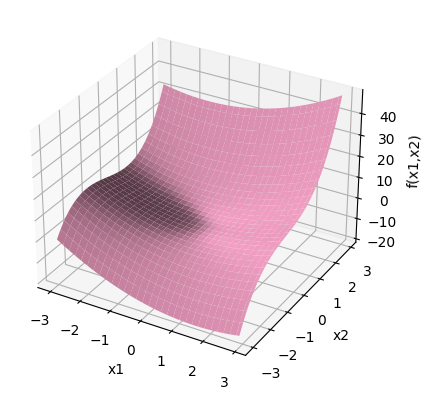

In [62]:
from mpl_toolkits.mplot3d import Axes3D

# 使用numpy.meshgrid生成x1,x2矩阵，矩阵的每一行为[-3, 3]，以0.1为间隔的数值
x1 = np.arange(-3, 3, 0.1)
x2 = np.arange(-3, 3, 0.1)
x1, x2 = np.meshgrid(x1, x2)
init_x = paddle.to_tensor([x1, x2])
model = OptimizedFunction3D()

# 绘制f_3d函数的三维图像
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(init_x[0], init_x[1], model(init_x), color="#f19ec2")
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('f(x1,x2)')
plt.savefig('opti-f-3d.pdf')

In [63]:
from IPython.display import HTML

labels = ['SGD', 'AdaGrad', 'RMSprop', 'Momentum', 'Adam']
colors = ['#9c9d9f', '#f7d2e2', '#f19ec2', '#e86096', '#000000']

anim = Visualization3D(*x_all_opts, z_values=z_all_opts, labels=labels, colors=colors, fig=fig, ax=ax)
ax.legend(loc='upper left')
HTML(anim.to_html5_video())

C:\Users\Dragon_Reed\AppData\Roaming\Python\Python310\site-packages\mpl_toolkits\mplot3d\proj3d.py:109: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


参数初始化

In [64]:
def xavier_normal_std(input_size, output_size):
    return np.sqrt(2 / (input_size + output_size))

In [67]:
class MLP(nn.Layer):
    def __init__(self, layers_size, init_fn_name, init_fn, act_fn):
        """
        多层网络初始化
        输入：
            - layers_size: 每层神经元的数量
            - init_fn_name: 网络中参数初始化方法，可以为 'normal'或'uniform'
            - init_fn: 函数，用来计算高斯分布标准差或均匀分布r值
            - act_fn: 激活函数
        """
        super(MLP, self).__init__()
        self.linear = nn.Sequential()
        self.num_layers = len(layers_size) - 1
        for i in range(self.num_layers):
            input_size, output_size = layers_size[i], layers_size[i + 1]
            if init_fn_name == 'normal':
                # Xavier高斯分布初始化，计算方差
                self.linear.add_sublayer(str(i), nn.Linear(input_size, output_size,
                                           weight_attr=nn.initializer.Normal(mean=0, std=init_fn(input_size, output_size))))
            elif init_fn_name == 'uniform':
                r = init_fn(input_size, output_size)
                self.linear.add_sublayer(str(i), nn.Linear(input_size, output_size, weight_attr=nn.initializer.Uniform(low=-r, high=r)))
            else:
                self.linear.add_sublayer(str(i), nn.Linear(input_size, output_size, weight_attr=nn.initializer.Normal()))
        self.act_fn = act_fn()
        self.z = {}

    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        """
        前向计算
        """
        y = X
        for num_layer in range(self.num_layers):
            y = self.linear[num_layer](y)
            if num_layer != self.num_layers-1:
                y = self.act_fn(y)
            self.z[num_layer] = y
        return y  

In [68]:
paddle.seed(0)

# 定义网络每层神经元数量
layers_size = [100, 200, 400, 300, 200, 100]

# 指定激活函数
activate_fn = paddle.nn.Tanh

# 指定参数初始化方式
init_fn_name = 'normal'

model = MLP(layers_size=layers_size, init_fn_name=init_fn_name, init_fn=xavier_normal_std, act_fn=activate_fn)

inputs = paddle.normal(shape=[1, 100], std=0.1)

y = model(inputs)

In [69]:
for i in range(len(model.z) - 1):
    print('layer %d: , %f'%(i, model.z[i].numpy().var()))

layer 0: , 0.004842
layer 1: , 0.003466
layer 2: , 0.004390
layer 3: , 0.004913


In [70]:
def xavier_uniform_r(input_size, output_size):
    return np.sqrt(6 / (input_size+output_size))

In [71]:
paddle.seed(0)

# 指定激活函数
activate_fn = paddle.nn.Tanh

# 指定参数初始化方式
init_fn_name = 'uniform'

model = MLP(layers_size=layers_size, init_fn_name=init_fn_name, init_fn=xavier_uniform_r, act_fn=activate_fn)

inputs = paddle.normal(shape=[1, 100], std=0.1)
y = model(inputs)

In [72]:
for i in range(len(model.z)-1):
    print('layer %d:, %f'%(i, model.z[i].numpy().var()))

layer 0:, 0.004853
layer 1:, 0.002944
layer 2:, 0.003479
layer 3:, 0.004650


In [73]:
from nndl_7 import make_moons

class MoonsDataset(io.Dataset):
    def __init__(self, mode='train', num_samples=300, num_train=200):
        super(MoonsDataset, self).__init__()
        X, y = make_moons(n_samples=num_samples, shuffle=True, noise=0.5)
        if mode =='train':
            self.X, self.y = X[:num_train], y[:num_train]
        else:
            self.X, self.y = X[num_train:], y[num_train:]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.y)

In [74]:
paddle.seed(0)

train_dataset = MoonsDataset(mode='train')
dev_dataset = MoonsDataset(mode='dev')

train_loader = io.DataLoader(train_dataset, batch_size=10, shuffle=True)
dev_loader = io.DataLoader(dev_dataset, batch_size=10, shuffle=True)

In [75]:
import nndl_7

paddle.seed(0)
np.random.seed(0)

# 定义网络每层神经元的数量
layers_size = [2, 300, 500, 700, 400, 1]
# 指定激活函数
activate_fn = paddle.nn.Tanh

# 指定参数初始化方式为Xavier高斯分布初始化
init_fn_name = 'normal'

model1 = MLP(layers_size=layers_size, init_fn_name=init_fn_name, init_fn=xavier_normal_std, act_fn=activate_fn)
opt1 = optimizer.SGD(learning_rate=0.005, parameters=model1.parameters())
loss_fn = F.binary_cross_entropy_with_logits
m = nndl_7.Accuracy(is_logist=True)
runner1 = RunnerV3(model=model1, optimizer=opt1, loss_fn=loss_fn, metric=m)
runner1.train(train_loader=train_loader, dev_loader=dev_loader, num_epochs=100, eval_steps=400, log_steps=0)

# 指定参数初始化方式为N(0, 1)高斯分布初始化
init_fn_name = 'basic'
model2 = MLP(layers_size=layers_size, init_fn_name=init_fn_name, init_fn=None, act_fn=activate_fn)
opt2 = optimizer.SGD(learning_rate=0.005, parameters=model2.parameters())
runner2 = RunnerV3(model=model2, optimizer=opt2, loss_fn=loss_fn, metric=m)
runner2.train(train_loader=train_loader, dev_loader=dev_loader, num_epochs=100, eval_steps=400, log_steps=0)


[Evaluate]  dev score: 0.86000, dev loss: 0.36434
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.86000
[Evaluate]  dev score: 0.86000, dev loss: 0.36272
[Evaluate]  dev score: 0.86000, dev loss: 0.36162
[Evaluate]  dev score: 0.86000, dev loss: 0.36156
[Evaluate]  dev score: 0.86000, dev loss: 0.36200
[Train] Training done!
[Evaluate]  dev score: 0.71000, dev loss: 2.32774
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.71000
[Evaluate]  dev score: 0.78000, dev loss: 1.81989
[Evaluate] best accuracy performence has been updated: 0.71000 --> 0.78000
[Evaluate]  dev score: 0.70000, dev loss: 2.87863
[Evaluate]  dev score: 0.75000, dev loss: 2.69242
[Evaluate]  dev score: 0.82000, dev loss: 1.65218
[Evaluate] best accuracy performence has been updated: 0.78000 --> 0.82000
[Train] Training done!


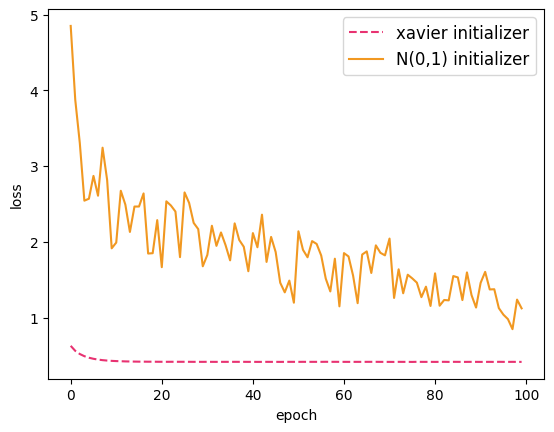

In [77]:
fig, ax = plt.subplots()
plt.plot(runner1.train_epoch_losses, label='xavier initializer', c='#e83271', linestyle='--')
plt.plot(runner2.train_epoch_losses, label='N(0,1) initializer', c='#f19821')
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
plt.legend(fontsize='large')
plt.savefig('opt-xavier.pdf')
plt.show()

逐层规范化

In [86]:
# BatchNorm算子
class BatchNorm(nn.Layer):
    def __init__(self, num_features, eps=1e-7, momentum=0.9, gamma=1.0, beta=0.0):
        """
        批量规范化初始化
        输入:
            - num_features: 输入特征数
            - eps: 保持数值稳定性而设置的常数
            - momentum: 用于计算移动平均值
            - gamma: 缩放的参数
            - beta: 平移的参数
        """
        super(BatchNorm, self).__init__()
        shape = (1, num_features)
        self.gamma = paddle.to_tensor(gamma, dtype='float32')
        self.beta = paddle.to_tensor(beta, dtype='float32')
        self.moving_mean = paddle.zeros(shape)
        self.moving_variance = paddle.ones(shape)
        self.eps = eps
        self.momentum = momentum

    def __call__(self, X, train_mode=True):
        return self.forward(X, train_mode)
    
    def forward(self, X, train_mode=True):
        if not train_mode:
            X = (X-self.moving_mean) / paddle.sqrt(self.moving_variance+self.eps)
        else:
            assert len(X.shape) in (2, 4)
            if len(X.shape) == 2:
                # 对于Liear层
                mean = paddle.mean(X, axis=0)
                var = ((X-mean)**2).mean(axis=0)
            else:
                # 对于卷积层
                mean = paddle.mean(X, axis=[0, 2, 3], keepdim=True)
                var = ((X-mean)**2).mean(axis=[0, 2, 3], keepdim=True)
            X = (X-mean) / paddle.sqrt(var, self.eps)
            # 保存移动平均值
            self.moving_mean = self.momentum*self.moving_mean+(1.-self.momentum)*mean
            self.moving_variance = self.momentum*self.moving_variance+(1.-self.momentum)*var
        y = self.gamma*X+self.beta
        return y

In [87]:
class MLP(nn.Layer):
    def __init__(self, layers_size, init_fn_name, init_fn, act_fn, norm_name=None, gamma=None, beta=None):
        """
        多层网络初始化
        输入：
            - layers_size: 每层神经元的数量
            - init_fn_name: 网络中参数初始化方法
            - init_fn: 计算高斯分布标准差或均匀分布r值
            - act_fn: 激活函数
            - norm_name: 使用哪一种逐层规范化
            - gamma、beta: 缩放和平移变换的参数
        """
        super(MLP, self).__init__()
        self.linear = paddle.nn.Sequential()
        self.normalization = {}
        self.num_layers = len(layers_size)-1
        for i in range(self.num_layers):
            input_size, output_size = layers_size[i], layers_size[i+1]
            if init_fn_name == 'normal':
                # Xavier高斯分布初始化，计算方差
                self.linear.add_sublayer(str(i), nn.Linear(in_features=input_size, out_features=output_size, 
                                                           weight_attr=nn.initializer.Normal(mean=0, std=init_fn(input_size, output_size))))
            elif init_fn_name == 'uniform':
                r = init_fn(input_size, output_size)
                self.linear.add_sublayer(str(i), nn.Linear(input_size, output_size, weight_attr=nn.initializer.Uniform(low=-r, high=r)))
            else:
                self.linear.add_sublayer(str(i), nn.Linear(in_features=input_size, out_features=output_size, weight_attr=nn.initializer.Normal()))
            # 判断是否使用逐层规范化，以及使用哪一种逐层规范化
            if norm_name == 'bn':
                self.normalization[i] = BatchNorm(output_size, gamma=gamma[i], beta=beta[i])
            elif norm_name == 'ln':
            # LayerNorm：对一个中间层的所有神经元进行规范化
                self.normalization[i] = LayerNorm(gamma=gamma[i], beta=beta[i])
        self.act_fn = act_fn()
        self.norm_name = norm_name
        self.z = {}
    
    def __call__(self, X, train_mode=True):
        return self.forward(X, train_mode)
    
    def forward(self, X, train_mode=True):
        y = X
        for num_layer in range(self.num_layers):
            y = self.linear[num_layer](y)
            if num_layer != self.num_layers-1:
                if self.norm_name == 'bn':
                    y = self.normalization[num_layer](y, train_mode)
                elif self.norm_name == 'ln':
                    y = self.normalization[num_layer](y)
                # 为了展示逐层规范化后的输出的均值和方差，使用z[num_layer]进行记录
                self.z[num_layer] = y
                y = self.act_fn(y)
        return y

In [88]:

paddle.seed(0)

# 定义每层神经元的数量
layers_size = [100, 200, 400, 300, 2, 2]

data = paddle.randn(shape=[200, 100])
print('data mean: ',data.numpy().mean())
print('data std: ', data.numpy().std())

activate_fn = paddle.nn.Tanh
model1 = MLP(layers_size=layers_size, init_fn_name='basic', init_fn=None, act_fn=activate_fn)
output = model1(data)

print('no batch normalization: ')
print('model output mean: ', model1.z[3].numpy().mean(axis=0))
print('model output std: ', model1.z[3].numpy().std(axis=0))

gamma = [1, 1, 1, 1, 1]
beta = [0, 0, 0, 0, 0]
model2 = MLP(layers_size=layers_size, init_fn_name='basic', init_fn=None, act_fn=activate_fn, norm_name='bn', gamma=gamma, beta=beta)
output = model2(data)
print('with batch normalization: ')
print('model output mean: ', model2.z[3].numpy().mean(axis=0))
print('model output std: ', model2.z[3].numpy().std(axis=0))

data mean:  -0.009602482
data std:  1.000052
no batch normalization: 
model output mean:  [-0.2288229  1.048803 ]
model output std:  [15.769605 15.797411]
with batch normalization: 
model output mean:  [-8.9406965e-10 -7.1525572e-09]
model output std:  [0.9999998  0.99999994]


In [91]:
paddle.seed(0)

gamma = [1, 2, 3, 5, 4]
beta = [3, 2, 1, 2, 2]
model3 = MLP(layers_size=layers_size, init_fn_name='basic', init_fn=None, act_fn=activate_fn, norm_name='bn', gamma=gamma, beta=beta)
output = model3(data)
print('batch normalization with different gamma and beta for different layer: ')
print('output means with bn 0: ', model3.z[0].numpy().mean())
print('output stds with bn 0: ', model3.z[0].numpy().std())
print('output means with bn 3: ', model3.z[3].numpy().mean())
print('output stds with bn 3:', model3.z[3].numpy().std())

batch normalization with different gamma and beta for different layer: 
output means with bn 0:  2.9999998
output stds with bn 0:  1.0
output means with bn 3:  2.0
output stds with bn 3: 5.0


In [92]:
paddle.seed(0)

epochs = 50
for epoch in range(epochs):
    inputs = paddle.randn(shape=[200, 200])
    output = model3(data)

# 打印批量规范化中训练样本均值和方差的移动平均值
print('batch norm 3 moving mean: ', model3.normalization[3].moving_mean.numpy())
print('batch norm 3 moving variance: ', model3.normalization[3].moving_variance.numpy())

batch norm 3 moving mean:  [[1.208333  0.6799915]]
batch norm 3 moving variance:  [[209.52353 161.30661]]


In [93]:
paddle.seed(0)
input_test = paddle.randn(shape=[5, 100])
output = model3(input_test, train_mode=False)

In [95]:
from paddle.nn import Conv2D, MaxPool2D, Linear, BatchNorm2D

# 多层卷积神经网络实现
class MultiConvLayerNet(nn.Layer):
    def __init__(self, use_bn=False):
        super(MultiConvLayerNet, self).__init__()

        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv1 = Conv2D(in_channels=1, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，窗口的大小为2，步长为2
        self.maxpool1 = MaxPool2D(kernel_size=2, stride=2)
        # 定义卷积层，输出特征通道out_channels设置为20，卷积核的大小kernel_size为5，卷积步长stride=1，padding=2
        self.conv2 = Conv2D(in_channels=20, out_channels=20, kernel_size=5, stride=1, padding=2)
        # 定义池化层，窗口的大小为2，步长为2
        self.maxpool2 = MaxPool2D(kernel_size=2, stride=2)
        # 定义一层全连接层，输出维度是10
        self.fc = Linear(980, 10)
        if use_bn:
            # 定义批量规范化层
            self.batch_norm1 = BatchNorm2D(num_features=20)
            self.batch_norm2 = BatchNorm2D(num_features=20)
        self.use_bn = use_bn

    # 定义网络前向计算过程
    def forward(self, inputs):
        x = self.conv1(inputs)
        if self.use_bn:
            x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        if self.use_bn:
            x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.maxpool2(x)
        x = paddle.reshape(x, [x.shape[0], 980])
        x = self.fc(x)
        return x

In [101]:
from nndl_7 import Accuracy

paddle.seed(0)
# 确保从paddle.vision.datasets.MNIST中加载的图像数据是np.ndarray类型
paddle.vision.image.set_image_backend('cv2')

# 使用MNIST数据集
train_dataset = MNIST(mode='train', transform=transform)
train_loader = io.DataLoader(train_dataset, batch_size=64, shuffle=True)
dev_dataset = MNIST(mode='test', transform=transform)
dev_loader = io.DataLoader(train_dataset, batch_size=64)

model1 = MultiConvLayerNet(use_bn=False)
opt1 = paddle.optimizer.Adam(learning_rate=0.01, parameters=model1.parameters())
loss_fn = F.cross_entropy
metric = Accuracy()
runner1 = RunnerV3(model=model1, optimizer=opt1, loss_fn=loss_fn, metric=metric)
print('train network without batch normalization')
runner1.train(train_loader=train_loader, dev_loader=dev_loader, num_epochs=5, log_steps=0, eval_steps=300)

model2 = MultiConvLayerNet(use_bn=True)
opt2 = paddle.optimizer.Adam(learning_rate=0.01, parameters=model2.parameters())
runner2 = RunnerV3(model=model2, optimizer=opt2, loss_fn=loss_fn, metric=metric)
print('train network with batch normalization')
runner2.train(train_loader=train_loader, dev_loader=dev_loader, num_epochs=5, log_steps=0, eval_steps=300)

train network without batch normalization
[Evaluate]  dev score: 0.97412, dev loss: 0.08554
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.97412
[Evaluate]  dev score: 0.97217, dev loss: 0.08734
[Evaluate]  dev score: 0.98695, dev loss: 0.04310
[Evaluate] best accuracy performence has been updated: 0.97412 --> 0.98695
[Evaluate]  dev score: 0.98577, dev loss: 0.04537
[Evaluate]  dev score: 0.98365, dev loss: 0.05031
[Evaluate]  dev score: 0.98190, dev loss: 0.05896
[Evaluate]  dev score: 0.98265, dev loss: 0.05511
[Evaluate]  dev score: 0.97923, dev loss: 0.06542
[Evaluate]  dev score: 0.98668, dev loss: 0.04024
[Evaluate]  dev score: 0.98693, dev loss: 0.04367
[Evaluate]  dev score: 0.98860, dev loss: 0.03826
[Evaluate] best accuracy performence has been updated: 0.98695 --> 0.98860
[Evaluate]  dev score: 0.98775, dev loss: 0.03960
[Evaluate]  dev score: 0.98913, dev loss: 0.03442
[Evaluate] best accuracy performence has been updated: 0.98860 --> 0.98913
[Evaluat

d:\anaconda3\lib\site-packages\paddle\nn\layer\norm.py:712: UserWarning: When training, we now always track global mean and variance.
  warnings.warn(


[Evaluate]  dev score: 0.96843, dev loss: 0.10129
[Evaluate] best accuracy performence has been updated: 0.00000 --> 0.96843
[Evaluate]  dev score: 0.97955, dev loss: 0.06457
[Evaluate] best accuracy performence has been updated: 0.96843 --> 0.97955
[Evaluate]  dev score: 0.98207, dev loss: 0.05998
[Evaluate] best accuracy performence has been updated: 0.97955 --> 0.98207
[Evaluate]  dev score: 0.97725, dev loss: 0.06934
[Evaluate]  dev score: 0.97665, dev loss: 0.06963
[Evaluate]  dev score: 0.99003, dev loss: 0.03250
[Evaluate] best accuracy performence has been updated: 0.98207 --> 0.99003
[Evaluate]  dev score: 0.98517, dev loss: 0.04623
[Evaluate]  dev score: 0.99048, dev loss: 0.03010
[Evaluate] best accuracy performence has been updated: 0.99003 --> 0.99048
[Evaluate]  dev score: 0.99118, dev loss: 0.02762
[Evaluate] best accuracy performence has been updated: 0.99048 --> 0.99118
[Evaluate]  dev score: 0.99283, dev loss: 0.02347
[Evaluate] best accuracy performence has been upda

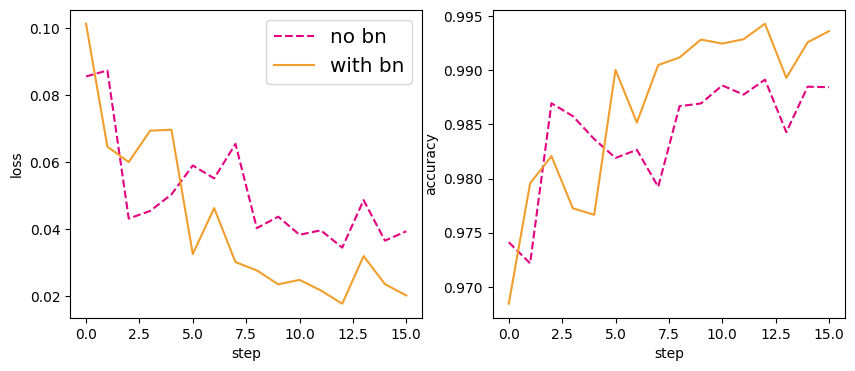

In [102]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(121)
ax1.plot(np.array(runner1.dev_losses)[:, 1], label='no bn', c='#e4007f', linestyle='--')
ax1.plot(np.array(runner2.dev_losses)[:, 1], label='with bn', c='#f19e2c')
ax1.set_xlabel('step')
ax1.set_ylabel('loss')
plt.legend(fontsize='x-large')
ax2 = plt.subplot(122)
ax2.plot(runner1.dev_scores, label='no bn', c='#e4007f', linestyle='--')
ax2.plot(runner2.dev_scores, label='with bn', c='#f19e2c')
ax2.set_xlabel('step')
ax2.set_ylabel('accuracy')
plt.savefig('opti-acc.pdf')
plt.show()

In [104]:
class LayerNorm(nn.Layer):
    def __init__(self, eps=1e-7, gamma=1.0, beta=0.0):
        """
        层规范化初始化
        输入:
            - eps: 保持数值稳定性而设置的常数
            - gamma: 缩放的参数
            - beta: 平移的参数
        """
        super().__init__(self.__class__.__name__)
        self.gamma = paddle.to_tensor(gamma, dtype='float32')
        self.beta = paddle.to_tensor(beta, dtype='float32')
        self.eps = eps

    def forward(self, X):
        # 层规范化对每个样本的每个特征进行规范化
        assert len(X.shape) in (2, 3, 4)
        if len(X.shape) == 4:
            mean = paddle.mean(X, axis=[1, 2, 3], keepdim=True)
            var = ((X-mean)**2).mean(axis=[1, 2, 3], keepdim=True)
        else:
            mean = paddle.mean(X, axis=-1, keepdim=True)
            var = ((X-mean)**2).mean(axis=-1, keepdim=True)
        X = (X-mean) / paddle.sqrt(var, self.eps)
        y = self.gamma*X + self.beta
        return y

In [107]:
paddle.seed(0)

# 定义网络每层神经元的数量
layers_size = [100, 200, 400, 300, 2, 2]

# 生成随机数据
data = paddle.randn(shape=[10, 100])
activate_fn = paddle.nn.Tanh
gamma = [1, 2, 3, 5, 4]
beta = [3, 2, 1, 2, 2]
model = MLP(layers_size=layers_size, init_fn_name='basic', init_fn=None, act_fn=activate_fn, norm_name='ln', gamma=gamma, beta=beta)
output = model(data)
print('layer normalization with different gamma and beta for different layer: ')
print('output means with ln 0:', model.z[0].numpy().mean(axis=-1))
print('output stds with ln 0: ', model.z[0].numpy().std(axis=-1))
print('output means with ln 1: ', model.z[3].numpy().mean(axis=-1))
print('output stds with ln 1: ', model.z[3].numpy().std(axis=-1))

layer normalization with different gamma and beta for different layer: 
output means with ln 0: [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
output stds with ln 0:  [1.        1.        1.        1.        1.        1.        0.9999999
 1.        1.        1.       ]
output means with ln 1:  [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
output stds with ln 1:  [5.        5.        5.0000005 5.        5.        5.        5.
 5.0000005 5.        5.       ]


网络正则化

In [108]:
# 数据集构建

paddle.seed(1)

# 采样300个样本
n_samples = 300 
num_train = 200

# 根据make_moons生成二分类数据集
data_X, data_y =make_moons(n_samples=n_samples, shuffle=True, noise=0.5)
X_train, y_train = data_X[:num_train], data_y[:num_train]
X_test, y_test = data_X[num_train:], data_y[num_train:]

y_train = y_train.reshape([-1, 1])
y_test = y_test.reshape([-1, 1])
print('train dataset X shape: ', X_train.shape)
print('train dataset y shape: ', y_train.shape)
print(X_train[0])

train dataset X shape:  [200, 2]
train dataset y shape:  [200, 1]
Tensor(shape=[2], dtype=float32, place=Place(gpu:0), stop_gradient=True,
       [ 0.07696825, -0.03301120])


In [118]:
class ReLU(Op):
    def __init__(self):
        self.inputs = None
        self.outputs = None
        self.params = None
    
    def forward(self, inputs):
        self.inputs = inputs
        return paddle.multiply(inputs, paddle.to_tensor(inputs>0, dtype='float32'))
    
    def backward(self, outputs_grads):
        # 计算ReLU激活函数对输入的导数
        # paddle.multiply是逐元素相乘算子
        return paddle.multiply(outputs_grads, paddle.to_tensor(self.inputs>0, dtype='float32'))

In [141]:
# 自定义多层感知机
from nndl_7 import op

class MLP_3L(Op):
    def __init__(self, layers_size):
        self.fc1 = op.Linear(layers_size[0], layers_size[1], name='fc1')
        # ReLU激活函数
        self.act_fn1 = ReLU()
        self.fc2 = op.Linear(layers_size[1], layers_size[2], name='fc2')
        self.act_fn2 = ReLU()
        self.fc3 = op.Linear(layers_size[2], layers_size[3], name='fc3')
        self.layers = [self.fc1, self.act_fn1, self.fc2, self.act_fn2, self.fc3]

    def __call__(self, X):
        return self.forward(X)
    
    def forward(self, X):
        z1 = self.fc1(X)
        a1 = self.act_fn1(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn2(z2)
        z3 = self.fc3(a2)
        return z3
    
    def backward(self, loss_grad_z3):
        loss_grad_a2 = self.fc3.backward(loss_grad_z3)
        loss_grad_z2 = self.act_fn2.backward(loss_grad_a2)
        loss_grad_a1 = self.fc2.backward(loss_grad_z2)
        loss_grad_z1 = self.act_fn1.backward(loss_grad_a1)
        loss_grad_inputs = self.fc1.backward(loss_grad_z1)

In [142]:
class BinaryCrossEntropyWithLogits(Op):
    def __init__(self, model):
        self.predicts = None
        self.labels = None
        self.data_size = None
        self.model = model
        self.logistic = op.Logistic()

    def __call__(self, logits, labels):
        return self.forward(logits, labels)
    
    def forward(self, logits, labels):
        self.predicts = self.logistic(logits)
        self.labels = labels
        self.data_size = self.predicts.shape[0]
        loss = -1. / self.data_size * (paddle.matmul(self.labels.t(), paddle.log(self.predicts)) + paddle.matmul((1-self.labels.t()), paddle.log(1-self.predicts)))
        loss = paddle.squeeze(loss, axis=1)
        return loss
    
    def backward(self):
        input_grads = 1. / self.data_size*(self.predicts - self.labels)
        self.model.backward(input_grads)

In [143]:
def accuracy_logits(logits, labels):
    """
    输入:
        - logits: 预测值，二分类时，shape=[N, 1]，N为样本数量; 多分类时，shape=[N, C]，C为类别数量
        - labels: 真实标签，shape=[N, 1]
    输出:
        - 准确率: shape=[1]
    """
    # 判断是二分类任务还是多分类任务，preds.shape[1]=1时为二分类任务，preds.shape[1]>1时为多分类任务
    if logits.shape[1] == 1:
        # 二分类时，判断每个logits是否大于0，当大于0时类别为1，否则类别为0
        # 使用'paddle.cast'将preds的数据类型转换为float32类型
        preds = paddle.cast((logits > 0), dtype='float32')
    else:
        # 多分类时，使用'paddle.argmax'计算最大元素索引作为类别
        preds = paddle.argmax(logits, axis=1, dtype='int32')
    return paddle.mean(paddle.cast(paddle.equal(preds, labels), dtype='float32'))

In [144]:
def train_model(X_train, y_train, X_test, y_test, model, optimizer, loss_fn, num_iters, *args):
    """
    训练模型
    输入：
        - X_train, y_train: 训练集数据
        - X_test, y_test: 测试集数据
        - model: 定义网络
        - optimizer: 优化器
        - loss_fn: 损失函数
        - num_iters: 训练迭代次数
        - args: 在dropout中指定模型为训练模式或评价模式
    """
    losses = []
    for i in range(num_iters):
        # 前向计算
        train_logits = model(X_train)
        loss = loss_fn(train_logits, y_train)
        # 反向计算
        loss_fn.backward()
        # 更新参数
        optimizer.step()
        if i%100 == 0:
            losses.append(loss)

    train_logits = model(X_train, *args)
    acc_train = accuracy_logits(train_logits, y_train)
    test_logits = model(X_test, *args)
    acc_test = accuracy_logits(test_logits, y_test)
    print('train accuracy: ', acc_train.numpy())
    print('test accuracy: ', acc_test.numpy())
    return losses

In [145]:
from nndl_7.op import BatchGD

paddle.seed(0)
layers_size = [X_train.shape[1], 20, 3, 1]
model = MLP_3L(layers_size)
opt = BatchGD(init_lr=0.2, model=model)
loss_fn = BinaryCrossEntropyWithLogits(model=model)
losses = train_model(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=model, optimizer=opt, loss_fn=loss_fn, num_iters=50000)

train accuracy:  [0.91]
test accuracy:  [0.81]


In [146]:
def show_class_boundary(model, X_train, y_train, *args, fig_name):
    # 均匀生成40 000个数据点
    x1, x2 = paddle.meshgrid(paddle.linspace(-2, 3, 200), paddle.linspace(-3, 3, 200))
    x = paddle.stack([paddle.flatten(x1), paddle.flatten(x2)], axis=1)
    # 预测对应类别
    y = model(x, *args)
    y = paddle.cast((y>0), dtype='int32').squeeze()

    bg_colors = ['#f5f5f5' if y==1 else '#f19ec2' for y in y]
    label_colors = ['#000000' if train_label==0 else '#e4007f' for train_label in y_train]

    # 绘制类别区域
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.scatter(x[:,0].numpy(), x[:,1].numpy(), c=bg_colors)
    plt.scatter(X_train[:,0].numpy(), X_train[:,1].numpy(), marker='*', c=label_colors)
    plt.savefig(fig_name)

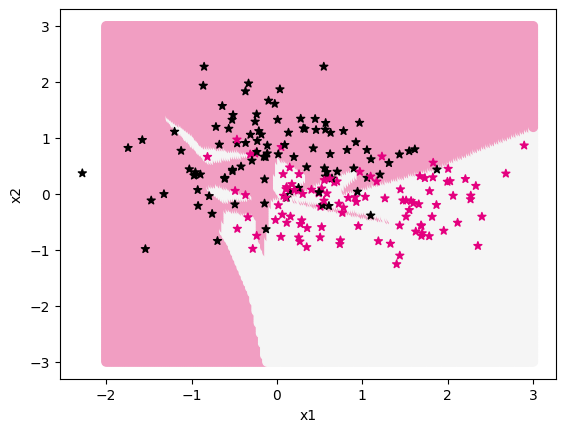

In [148]:
show_class_boundary(model=model, X_train=X_train, y_train=y_train, fig_name='opti-regulariation.pdf')

In [149]:
class BinaryCrossEntropyWithLogits(Op):
    def __init__(self, model, lambd):
        self.predicts = None
        self.labels = None
        self.data_size = None
        self.model = model
        self.logistic = op.Logistic()
        self.lambd = lambd
    
    def __call__(self, logits, labels):
        return self.forward(logits, labels)
    
    def forward(self, logits, labels):
        self.predicts = self.logistic(logits)
        self.labels = labels
        self.data_size = self.predicts.shape[0]
        loss = -1. /self.data_size * (paddle.matmul(self.labels.t(), paddle.log(self.predicts)) + paddle.matmul((1-self.labels.t()), paddle.log(1-self.predicts)))
        loss = paddle.squeeze(loss, axis=1)
        regularization_loss = 0
        for layer in self.model.layers:
            if isinstance(layer, op.Linear):
                regularization_loss += paddle.sum(paddle.square(layer.params['W']))
        loss += self.lambd * regularization_loss / (2*self.data_size)
        return loss
    
    def backward(self):
        inputs_grads = 1./self.data_size * (self.predicts - self.labels)
        self.model.backward(inputs_grads)
        #更新正则化项对应的梯度
        for layer in self.model.layers:
            if isinstance(layer, op.Linear) and isinstance(layer.grads, dict):
                layer.grads['W'] += self.lambd * layer.params['W'] / self.data_size

In [151]:
paddle.seed(0)
model = MLP_3L(layers_size)
opt = BatchGD(init_lr=0.2, model=model)
loss_fn = BinaryCrossEntropyWithLogits(model, lambd=0.7)
losses = train_model(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=model, optimizer=opt, loss_fn=loss_fn, num_iters=50000)

train accuracy:  [0.88]
test accuracy:  [0.85]


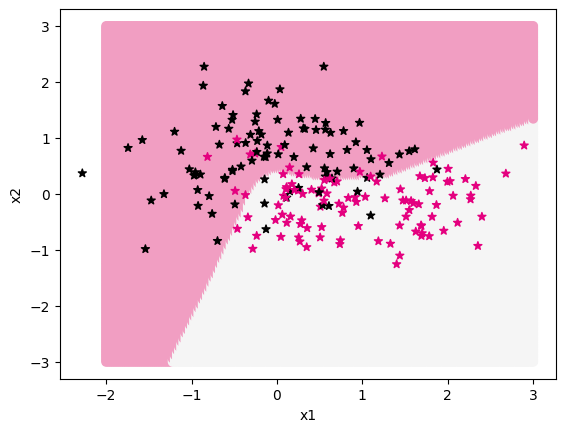

In [152]:
show_class_boundary(model=model, X_train=X_train, y_train=y_train, fig_name='opti-regularation2.pdf')

In [153]:
class BatchGD(Optimizer):
    def __init__(self, init_lr, model, weight_decay):
        """
        小批量梯度下降优化器初始化
        输入：
            - init_lr: 初始学习率
            - model：模型，model.params字典存储模型参数值
        """
        super(BatchGD, self).__init__(init_lr=init_lr, model=model)
        self.weight_decay = weight_decay

    def gradient_descent(self, x, gradient_x, init_lr):
        """
        梯度下降更新一次参数
        """
        x = (1-self.weight_decay)*x -init_lr*gradient_x
        return x
    
    def step(self):
        """
        参数更新
        输入：
            - gradient：梯度字典，存储每个参数的梯度
        """
        for layer in self.model.layers:
            if isinstance(layer.params, dict):
                for key in layer.params.keys():
                    layer.params[key] = self.gradient_descent(layer.params[key], layer.grads[key], self.init_lr)

In [154]:
paddle.seed(0)
model = MLP_3L(layers_size=layers_size)
opt = BatchGD(init_lr=0.2, model=model, weight_decay=0.001)
loss_fn = BinaryCrossEntropyWithLogits(model=model, lambd=0)
losses = train_model(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=model, optimizer=opt, loss_fn=loss_fn, num_iters=50000)

train accuracy:  [0.875]
test accuracy:  [0.85]


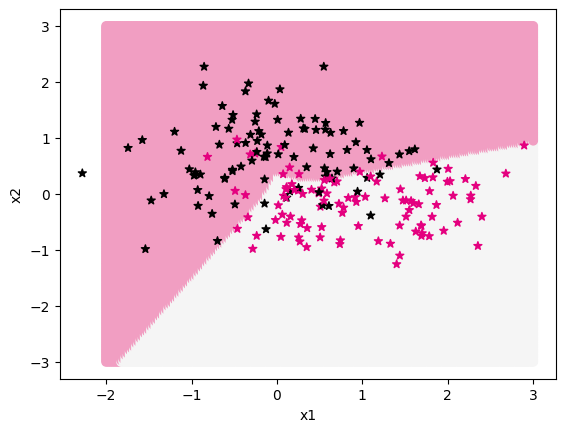

In [156]:
show_class_boundary(model=model, X_train=X_train, y_train=y_train, fig_name='opti-regularization3.pdf')

In [165]:
# 暂退法(Dropout Method)

class Dropout(Op):
    def __init__(self, drop_rate):
        self.mask = None
        self.drop_rate = drop_rate
    
    def forward(self, inputs):
        # 生成一个丢弃掩码
        mask = paddle.cast(paddle.rand(inputs.shape) > self.drop_rate, dtype='float32')
        self.mask =mask
        # 随机使一些神经元失效
        inputs = paddle.multiply(inputs, mask)
        # 使输入方差保持不变
        inputs /= (1-self.drop_rate)
        return inputs
    
    def backward(self, outputs_grads):
        return paddle.multiply(outputs_grads, self.mask) / (1-self.drop_rate)

In [166]:
from nndl_7.op import  MLP_3L

class MLP_3L_dropout(MLP_3L):
    def __init__(self, layers_size, drop_rate):
        super(MLP_3L_dropout, self).__init__(layers_size)
        self.dropout1 = Dropout(drop_rate)
        self.dropout2 = Dropout(drop_rate)
        self.layers = [self.fc1, self.act_fn1, self.fc2, self.act_fn2, self.fc3]

    def __call__(self, X, mode='train'):
        return self.forward(X,mode)
    
    def forward(self, X, mode='train'):
        self.mode = mode
        z1 = self.fc1(X)
        a1 = self.act_fn1(z1)
        if self.mode == 'train':
            a1 = self.dropout1(a1)
        z2 = self.fc2(a1)
        a2 = self.act_fn2(z2)
        if self.mode == 'train':
            a2 = self.dropout2(a2)
        z3 = self.fc3(a2)
        return z3
    
    def backward(self, loss_grad_z3):
        loss_grad_a2 = self.fc3.backward(loss_grad_z3)
        if self.mode == 'train':
            loss_grad_a2 = self.dropout2.backward(loss_grad_a2)
        loss_grad_z2 = self.act_fn2.backward(loss_grad_a2)
        loss_grad_a1 = self.fc2.backward(loss_grad_z2)
        if self.mode == 'train':
            loss_grad_a1 = self.dropout1.backward(loss_grad_a1)
        loss_grad_z1 = self.act_fn1.backward(loss_grad_a1)
        loss_grad_inputs = self.fc1.backward(loss_grad_z1)

In [168]:
paddle.seed(0)
model = MLP_3L_dropout(layers_size=layers_size, drop_rate=0.3)
opt = BatchGD(init_lr=0.2, model=model, weight_decay=0)
loss_fn = BinaryCrossEntropyWithLogits(model=model, lambd=0)
losses = train_model(X_train, y_train, X_test, y_test, model, opt, loss_fn, 50000, 'dev')

train accuracy:  [0.87499994]
test accuracy:  [0.84000003]


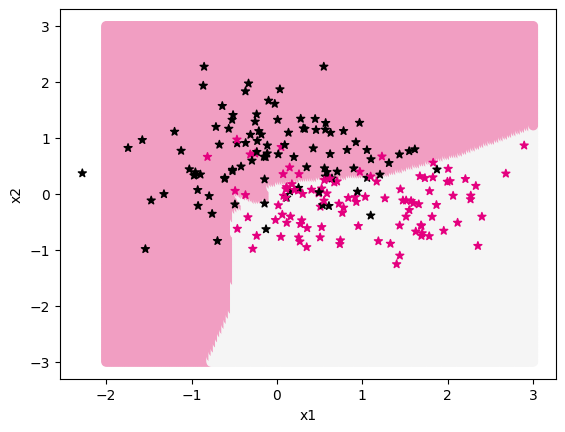

In [169]:
show_class_boundary(model, X_train, y_train, 'dev', fig_name='opti-regularization4.pdf')

In [170]:
class MLP_3L_Paddle(nn.Layer):
    def __init__(self, in_features, out_features):
        super(MLP_3L_Paddle, self).__init__()
        self.fc1 = nn.Linear(in_features=in_features, out_features=20)
        self.fc2 = nn.Linear(in_features=20, out_features=3)
        self.fc3 = nn.Linear(in_features=3, out_features=out_features)
        self.act_fn = nn.ReLU()

    def forward(self, X):
        z1 = self.fc1(X)
        a1 = self.act_fn(z1)
        z2 = self.fc2(a1)
        a2 = self.act_fn(z2)
        z3 = self.fc3(a2)
        return z3

In [171]:
def train_model_paddle(X_train, y_train, X_test, y_test, model, optimizer, loss_fn, num_iters):
    """
    训练模型
    输入：
        - X_train, y_train: 训练集数据
        - X_test, y_test: 测试集数据
        - model: 定义网络
        - optimizer: 优化器
        - loss_fn: 损失函数
        - num_iters: 训练迭代次数
        - args: 在dropout中指定模型为训练模式或评价模式
    """
    losses = []
    for i in range(num_iters):
        # 前向计算
        train_logits = model(X_train)
        loss = loss_fn(train_logits, y_train)
        # 反向计算
        loss.backward()
        # 更新参数
        optimizer.step()
        optimizer.clear_grad()
        if i % 100 == 0:
            losses.append(loss)

    train_logits = model(X_train)
    acc_train = accuracy_logits(train_logits, y_train)
    test_logits = model(X_test)
    acc_test = accuracy_logits(test_logits, y_test)
    print('train accuracy: ', acc_train.numpy())
    print('test accuracy: ', acc_test.numpy())
    return losses

In [172]:
paddle.seed(0)
model = MLP_3L_Paddle(in_features=X_train.shape[1], out_features=1)
opt = paddle.optimizer.SGD(learning_rate=0.2, parameters=model.parameters())
loss_fn = F.binary_cross_entropy_with_logits
losses = train_model_paddle(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=model, optimizer=opt,loss_fn=loss_fn, num_iters=50000)

train accuracy:  [0.935]
test accuracy:  [0.84]


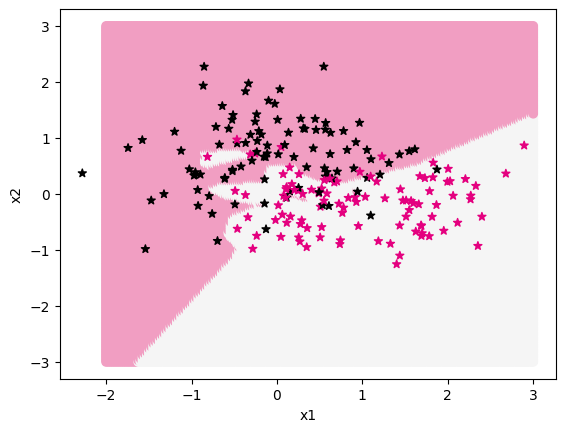

In [173]:
show_class_boundary(model=model, X_train=X_train, y_train=y_train, fig_name='opti-regularization4.pdf')

In [175]:
import paddle.regularizer as regularizer

paddle.seed(0)
model = MLP_3L_Paddle(in_features=X_train.shape[1], out_features=1)
opt = paddle.optimizer.SGD(learning_rate=0.2, parameters=model.parameters(), weight_decay=regularizer.L2Decay(coeff=0.01))
loss_fn = F.binary_cross_entropy_with_logits
losses = train_model_paddle(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, model=model, optimizer=opt, loss_fn=loss_fn, num_iters=50000)

train accuracy:  [0.87499994]
test accuracy:  [0.86]


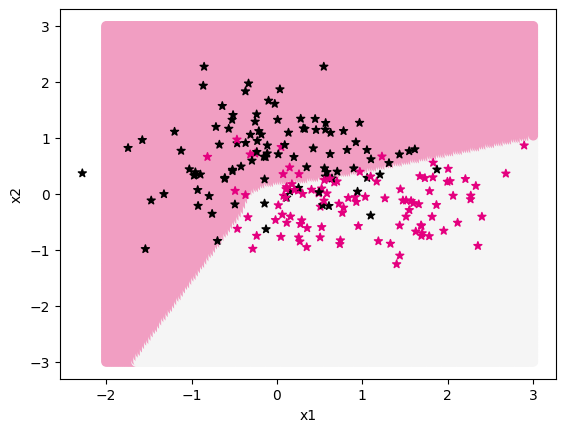

In [176]:
show_class_boundary(model=model, X_train=X_train, y_train=y_train, fig_name='opti-regularization5.pdf')